In [1]:
import numpy as np
from skimage import exposure
from skimage.filters import unsharp_mask
from skimage import io
from PIL import Image
import os
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2,ToTensor, ToPILImage, InterpolationMode
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
import random
from skimage import color
%matplotlib inline

2024-05-24 14:56:10.742413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 14:56:10.742537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 14:56:10.870340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = "/kaggle/input/raf-db-dataset"

In [3]:
dataset = load_dataset("imagefolder", data_dir=dataset_path)

labels = dataset["train"].features["label"].names

idx2label = {idx: label for idx, label in enumerate(labels)}
label2idx = {label: idx for idx, label in enumerate(labels)}

Resolving data files:   0%|          | 0/24543 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/6137 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
def show_images(images):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.axis("off")
        
def show_images_with_labels(images, labels):
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(zip(images, labels)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

In [5]:
random_indices = random.sample(range(len(dataset["train"])), 5)
random_images = [dataset["train"][i]['image'] for i in random_indices]
random_labels = [dataset["train"][i]['label'] for i in random_indices]

In [6]:
# show_images_with_labels(random_images, random_labels)

In [7]:
model_name = 'google/vit-base-patch16-224'

In [8]:

# def apply_processor(example):
#     example['pixel_values'] = processor(example['image'].convert("RGB"), return_tensors="pt").pixel_values.squeeze()
#     return example

# processed_dataset = dataset.map(apply_processor)

In [9]:
class HistogramEqualizer(torch.nn.Module):
    def forward(self, img):
        return Image.fromarray(np.uint8(exposure.equalize_adapthist(np.asarray(img))*255))

In [10]:
class UnsharpMasking(torch.nn.Module):
    def forward(self, img):
        return Image.fromarray(np.uint8(unsharp_mask(np.asarray(img),5,1, channel_axis=2)*255))

In [11]:
class rgb2hsv(torch.nn.Module):
    def forward(self, img):
        return Image.fromarray(np.uint8(color.rgb2hsv(np.asarray(img))*255))

In [12]:
class rgb2lab(torch.nn.Module):
    def forward(self, img):
        return Image.fromarray(np.uint8(color.rgb2lab(np.asarray(img))))

In [13]:
processor = ViTImageProcessor.from_pretrained(model_name, return_tensors = 'pt')
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = v2.Normalize(mean=image_mean, std=image_std)

train_transform = v2.Compose([
    HistogramEqualizer(),
    UnsharpMasking(),
#     rgb2lab(),
    v2.Resize((processor.size["height"], processor.size["width"]), interpolation=InterpolationMode.BILINEAR),
    v2.RandomHorizontalFlip(0.4),
    v2.RandomVerticalFlip(0.1),
    v2.RandomApply(transforms=[v2.RandomRotation(degrees=(0, 90))], p=0.5),
    v2.RandomApply(transforms=[v2.ColorJitter(brightness=.3, hue=.1)], p=0.3),
    v2.RandomApply(transforms=[v2.GaussianBlur(kernel_size=(5, 9))], p=0.3),
    v2.ToTensor(),
    normalize
 ])

test_transform = v2.Compose([
    HistogramEqualizer(),
    UnsharpMasking(),
#     rgb2lab(),
    v2.Resize((processor.size["height"], processor.size["width"]), interpolation=InterpolationMode.BILINEAR),
    v2.ToTensor(),
    normalize
])

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [14]:
def train_transforms(examples):
    examples['pixel_values'] = [train_transform(image.convert("RGB")) for image in examples['image']]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [test_transform(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
dataset['train'].set_transform(train_transforms)
dataset['test'].set_transform(test_transforms)

In [15]:
# to_pil_image = ToPILImage()

# # Get an example from the transformed dataset
# example = dataset['train'][5]  # Retrieve the first transformed sample

# # Assuming 'pixel_values' are normalized tensors
# pixel_values = example['pixel_values']

# # # Convert the first image tensor to a PIL image (if you have batched tensors, adjust accordingly)
# # image = to_pil_image(pixel_values)

# hsv_img = pixel_values.permute(1, 2, 0)

# # Extract hue and value channels
# hue_channel = hsv_img[:, :, 0]
# value_channel = hsv_img[:, :, 2]

# # Plot the hue and value channels
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Plot hue channel
# axes[0].imshow(hue_channel, cmap='hsv')
# axes[0].set_title('Hue Channel')
# axes[0].axis('off')

# # Plot value channel
# axes[1].imshow(value_channel)
# axes[1].set_title('Value Channel')
# axes[1].axis('off')

# plt.show()

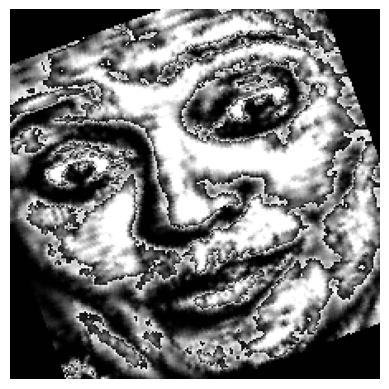

torch.Size([3, 224, 224])

In [16]:
to_pil_image = ToPILImage()

# Get an example from the transformed dataset
example = dataset['train'][100]  # Retrieve the first transformed sample

# Assuming 'pixel_values' are normalized tensors
pixel_values = example['pixel_values']

# Convert the first image tensor to a PIL image (if you have batched tensors, adjust accordingly)
image = to_pil_image(pixel_values)

# Plotting the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
pixel_values.shape

In [17]:
model = ViTForImageClassification.from_pretrained(model_name,
                                                  id2label=idx2label,
                                                  label2id=label2idx,
                                                  ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [19]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [20]:
experiment_name = "vit-base-face-recognition"
dir_ft = f'/kaggle/working/{experiment_name}/'

In [21]:
metric_name = "accuracy"

# Define Train Parameters
args = TrainingArguments(
    experiment_name,
    use_cpu = False,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=96,
    per_device_eval_batch_size=96,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    save_strategy = "epoch")

# Train
trainer = Trainer(
    model,
    args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [22]:
import wandb
wandb.login(key='b619c32148b781d6b76b10c9290b3e15c5a99c55')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [23]:
trainer.train()

wandb: Currently logged in as: m-motawie (nile-uni). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.837400,0.615963,0.788136
2,0.495100,0.539136,0.819426
3,0.336700,0.571040,0.823338
4,0.233000,0.624345,0.813559
5,0.158700,0.610586,0.842243
6,0.108500,0.637011,0.834420
7,0.078800,0.680364,0.844850
8,0.053900,0.675684,0.843872
9,0.034600,0.706794,0.849087
10,0.022500,0.689231,0.852347


TrainOutput(global_step=2560, training_loss=0.2358991863206029, metrics={'train_runtime': 10529.4358, 'train_samples_per_second': 23.308, 'train_steps_per_second': 0.243, 'total_flos': 1.901893635657437e+19, 'train_loss': 0.2358991863206029, 'epoch': 10.0})

In [24]:
trainer.save_model(dir_ft)